In this notebook we will load the optimized model which we saved in the previous notebook an will classify a given input audio file, either a .wav or .mp3

Note that this notebook is for explanation only. For the actual Web APP, we run the code as python script, which is `classify_cmd.py`. The input file comes from the direct recording or as a file upload from the APP, which is then passed on to the script as commanline argument like this

```sh
$ ./classify_cmd.py InputFile.mp3
```

The output from the script is then sent back to the APP interface as JSON and Base64 encdoded plot graphics.

# Loading the saved model

In [1]:
import pickle, glob, os

In [2]:
with open('VoteC_mfcc20.model','rb') as fh:
    model=pickle.load(fh)

# Loading a given input audio file

In [7]:
# We select a random audio file as input for testing

audio_file='genres/rock/rock.00005.wav'

In [10]:
import numpy as np
import librosa
import pandas as pd

In [ ]:
# To supress librosa warning message when reading a mp3 file
import warnings
warnings.filterwarnings('ignore')

This function is to extract features from a given audio file or from a loaded audio data 

This function is exactly same as we defined in Notebook 1 for feature extraction 

In [8]:

def get_features(file=None,n_mfcc=20, target_sr=22050):
    if not file:
        (sig, sr)=(np.array([0.0]), 1.0)
    else:
        if isinstance(file,tuple):
            (sig, sr)=file
            file='SignalData'
        else:
            (sig, sr) = librosa.load(file, sr=target_sr, mono=True)
        if sr!=target_sr:
            sig=librosa.resample(sig,sr,target_sr)
            sr=target_sr
    features={'file':file}
    mfcc=np.mean(librosa.feature.mfcc(sig, sr=sr,n_mfcc=n_mfcc),axis=1)
    for i in range(len(mfcc)):
        features['mfcc_'+str(i+1)] = mfcc[i]
    features['bandwidth'] = np.mean(librosa.feature.spectral_bandwidth(sig, sr=sr))
    features['rolloff'] = np.mean(librosa.feature.spectral_rolloff(sig, sr=sr))
    features['zero_cross'] = np.mean(librosa.feature.zero_crossing_rate(sig))
    features['chroma'] = np.mean(librosa.feature.chroma_stft(sig, sr=sr))
    features['centroid'] = np.mean(librosa.feature.spectral_centroid(sig, sr=sr))
    features['rms'] = np.mean(librosa.feature.rms(sig))
    return features

In [11]:
# Load the audio data from inpiut file

(sig, sr) = librosa.load(audio_file, sr=22050, mono=True)

# Applying the classifer model

Our audio data file may contain multipel genres in differnt sections, so we split the audio data into 30 seconds interval and apply classifier model on each part then take a mean of the probable genres.


For eaxmple if we have a 120 seconds audio piece, we split into small but 50% oerlapping intervals like this : [0,30], [15,45], [30,60], [45, 75], [60, 90], [75, 105], [90, 120] seconds.




In [12]:
#  split interval of 30 seconds or length of the audio file, whichever is lower

dt=min([30,len(sig)/sr])

In [16]:
# make list of split sections

intervals=[[iv, iv+int(sr*dt)]  for iv in list(range(0,len(sig)-int(sr*dt)+1,int(sr*dt/2)))]

In [17]:
# Extarct the features for each split section and put into a DataFrame

data=pd.DataFrame(columns=model['columns'])
for iv in intervals:
    data=data.append(get_features(( sig[iv[0]:iv[1]] , sr),model['n_mfcc']),ignore_index=True)

We now apply the classifer model to each section and get the prediction probabilities for every genre.

Then we take median of probabilites for all sections.



In [18]:
# Applying the classifer model and get the genre probabilities

pred_proba=model['model'].predict_proba(data[model['columns']])
median_poba=np.median(pred_proba,axis=0)
median_poba[median_poba<0.05]=0.0
median_poba=median_poba/median_poba.sum()

label_prob=[k for k in zip(sorted(model['genre_mapper'].keys()),median_poba) if k[1]>0.0]

pred_name=sorted(label_prob, key=lambda tup: tup[1], reverse=True)[0][0]

print("The most probable genre is "+pred_name)

The most probable genre is rock


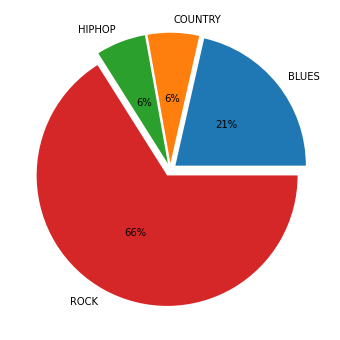

In [20]:
# We plot the probability pie-chart

import matplotlib.pyplot as plt
pie, ax = plt.subplots(figsize=[10,6])
labels = data.keys()
plt.pie(labels=[k[0].upper() for k in label_prob], x=[k[1] for k in label_prob], autopct="%1.f%%", explode=[0.05]*len(label_prob), pctdistance=0.5)
plt.show()